# Wine Price Time Series Analysis

In this notebook, I'm going to analyze wine prices using domestic wine production, exports, imports, average wine prices, and population datasets.

## Contents

1. Setup
2. Granger Causality Tests
3. Stationarity Transformations
4. Modeling
    - Lag Order Selection
    - Fit the Model
    - Serial Correlation of Residuals
    - Forecasting
    - Accuracy
5. Conclusion

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson

In [2]:
# Making plots a bit more accessible
style.use('fivethirtyeight')
sns.set_palette('colorblind')

### Import Data

In [3]:
df = pd.read_excel('../data/master-data.xlsx')
df.head()

,Unnamed: 0,month,population,price,price_adj,bulk,bottled,cider,effervescent,wine_gross,...,landed_duty_paid_value_ukfrspde_imports,landed_duty_paid_value_adj_ukfrspde_imports,customs_value_ukfrspde_imports,customs_value_adj_ukfrspde_imports,quantity_ukfrspde_imports,charges_insurance_freight_ukfrspde_imports,charges_insurance_freight_adj_ukfrspde_imports,calculated_duties_ukfrspde_imports,calculated_duties_adj_ukfrspde_imports,frspger_25
0,0,2000-01-31,281083000,5.458,5.299029,1.131505e+08,1.244070e+08,NaN,6.909175e+06,2.444667e+08,...,59812261,5.807016e+07,56706027,5.505440e+07,8768676,2406931,2.336826e+06,699303,678934.951456,0
1,1,2000-02-29,281299000,5.256,5.198813,7.179357e+07,1.375283e+08,NaN,4.377026e+06,2.136989e+08,...,77087577,7.624884e+07,73873201,7.306944e+07,8961916,2356486,2.330847e+06,857890,848555.885262,0
2,2,2000-03-31,281531000,5.471,5.311650,4.635628e+07,1.603837e+08,NaN,9.321474e+06,2.160614e+08,...,87219165,8.467880e+07,83500840,8.106878e+07,10474993,2804317,2.722638e+06,914008,887386.407767,0
3,3,2000-04-30,281763000,5.156,5.104950,3.296724e+07,1.423004e+08,2.045088e+06,7.881046e+06,1.811036e+08,...,87040067,8.617828e+07,83075769,8.225324e+07,11128077,2989501,2.959902e+06,974797,965145.544554,0
4,4,2000-05-31,281996000,5.530,5.426889,3.178035e+07,1.612658e+08,6.959646e+06,6.334834e+06,1.924214e+08,...,79534639,7.805166e+07,75599523,7.418991e+07,10874051,3037785,2.981143e+06,897331,880599.607458,0


In [4]:
df.set_index('month', inplace=True)
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

df.head()

,population,price,price_adj,bulk,bottled,cider,effervescent,wine_gross,bulk_adj,bottled_adj,...,landed_duty_paid_value_ukfrspde_imports,landed_duty_paid_value_adj_ukfrspde_imports,customs_value_ukfrspde_imports,customs_value_adj_ukfrspde_imports,quantity_ukfrspde_imports,charges_insurance_freight_ukfrspde_imports,charges_insurance_freight_adj_ukfrspde_imports,calculated_duties_ukfrspde_imports,calculated_duties_adj_ukfrspde_imports,frspger_25
month,,,,,,,,,,,,,,,,,,,,,
2000-01-31,281083000,5.458,5.299029,1.131505e+08,1.244070e+08,NaN,6.909175e+06,2.444667e+08,0.402552,0.442599,...,59812261,5.807016e+07,56706027,5.505440e+07,8768676,2406931,2.336826e+06,699303,678934.951456,0
2000-02-29,281299000,5.256,5.198813,7.179357e+07,1.375283e+08,NaN,4.377026e+06,2.136989e+08,0.255222,0.488904,...,77087577,7.624884e+07,73873201,7.306944e+07,8961916,2356486,2.330847e+06,857890,848555.885262,0
2000-03-31,281531000,5.471,5.311650,4.635628e+07,1.603837e+08,NaN,9.321474e+06,2.160614e+08,0.164658,0.569684,...,87219165,8.467880e+07,83500840,8.106878e+07,10474993,2804317,2.722638e+06,914008,887386.407767,0
2000-04-30,281763000,5.156,5.104950,3.296724e+07,1.423004e+08,2.045088e+06,7.881046e+06,1.811036e+08,0.117003,0.505036,...,87040067,8.617828e+07,83075769,8.225324e+07,11128077,2989501,2.959902e+06,974797,965145.544554,0
2000-05-31,281996000,5.530,5.426889,3.178035e+07,1.612658e+08,6.959646e+06,6.334834e+06,1.924214e+08,0.112698,0.571873,...,79534639,7.805166e+07,75599523,7.418991e+07,10874051,3037785,2.981143e+06,897331,880599.607458,0


## Granger Causality Tests

In [5]:
maxlag=16
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test=test, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    granger_df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in granger_df.columns:
        for r in granger_df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=16, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            granger_df.loc[r, c] = min_p_value
    granger_df.columns = [var + '_x' for var in variables]
    granger_df.index = [var + '_y' for var in variables]
    
    return granger_df

In [6]:
df.columns

Index(['population', 'price', 'price_adj', 'bulk', 'bottled', 'cider',
       'effervescent', 'wine_gross', 'bulk_adj', 'bottled_adj', 'cider_adj',
       'effervescent_adj', 'wine_gross_adj', 'quantity_exports',
       'fas_value_adj_exports', 'dutiable_value_world_imports',
       'dutiable_value_adj_world_imports',
       'landed_duty_paid_value_world_imports',
       'landed_duty_paid_value_adj_world_imports',
       'customs_value_world_imports', 'customs_value_adj_world_imports',
       'quantity_world_imports', 'charges_insurance_freight_world_imports',
       'charges_insurance_freight_adj_world_imports',
       'calculated_duties_world_imports',
       'calculated_duties_adj_world_imports',
       'dutiable_value_ukfrspde_imports',
       'dutiable_value_adj_ukfrspde_imports',
       'landed_duty_paid_value_ukfrspde_imports',
       'landed_duty_paid_value_adj_ukfrspde_imports',
       'customs_value_ukfrspde_imports', 'customs_value_adj_ukfrspde_imports',
       'quantity_ukf

In [7]:
gc_df = df[['population', 'price_adj', 'bulk', 'bottled',
    'dutiable_value_adj_world_imports', 'calculated_duties_adj_world_imports', 
    'dutiable_value_adj_ukfrspde_imports', 'calculated_duties_adj_ukfrspde_imports', 
    'quantity_world_imports', 'quantity_ukfrspde_imports']].copy()

In [8]:
granger_results = grangers_causation_matrix(data=df.dropna(), variables=df.columns)
granger_results.to_excel('../granger_results_master_df.xlsx')

In [9]:
gc_df.rename(columns={
    'population': 'pop',
    'price_adj': 'price',
    'dutiable_value_adj_world_imports': 'value world imports',
    'dutiable_value_adj_ukfrspde_imports': 'value subset imports',
    'calculated_duties_adj_world_imports': 'duties charges world',
    'calculated_duties_adj_ukfrspde_imports': 'duties charges subset',
    'quantity_world_imports': 'total world imports',
    'quantity_ukfrspde_imports': 'total subset imports'
}, inplace=True)

gc_test_results = grangers_causation_matrix(data=gc_df.dropna(), variables=gc_df.columns)

In [10]:
print(gc_test_results.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  pop\_x &  price\_x &  bulk\_x &  bottled\_x &  value world imports\_x &  duties charges world\_x &  value subset imports\_x &  duties charges subset\_x &  total world imports\_x &  total subset imports\_x \\
\midrule
pop\_y                   &    1.0 &   0.0001 &  0.0000 &     0.0000 &                 0.0000 &                  0.0000 &                     0.0 &                   0.0000 &                 0.0000 &                  0.0000 \\
price\_y                 &    0.0 &   1.0000 &  0.1349 &     0.0000 &                 0.0000 &                  0.0016 &                     0.0 &                   0.0283 &                 0.0000 &                  0.0000 \\
bulk\_y                  &    0.0 &   0.0000 &  1.0000 &     0.0000 &                 0.0000 &                  0.0000 &                     0.0 &                   0.0025 &                 0.0000 &                  0.0000 \\
bottled\_y               &    0.0 &   0.0000 &  0.0000 &     

## Stationary Transformation

Before getting started, let's define the Dickey-Fuller test for checking for stationarity.

The hypothesis for the Augmented Dickey-Fuller test is as follows:
$$h_0: \text{The series has a unit root}$$
$$h_1: \text{The series does not have a unit root}$$

In [11]:
def adf(col):
    print('Augmented Dickey-Fuller Test:')
    unit_root_test = adfuller(col, autolag='AIC')
    dfoutput = pd.Series(unit_root_test[0:4], index=['t-stat:','p-value:','lags:','observations:'])
    for key, value in unit_root_test[4].items():
       dfoutput['critical value (%s):' % key] = value
    print (dfoutput)

Let's also create a dataframe that contains all of the inputs to our multivariate timeseries model.

In [12]:
ts_df = df[['frspger_25']].copy()

### Price

Let's start with the price data.

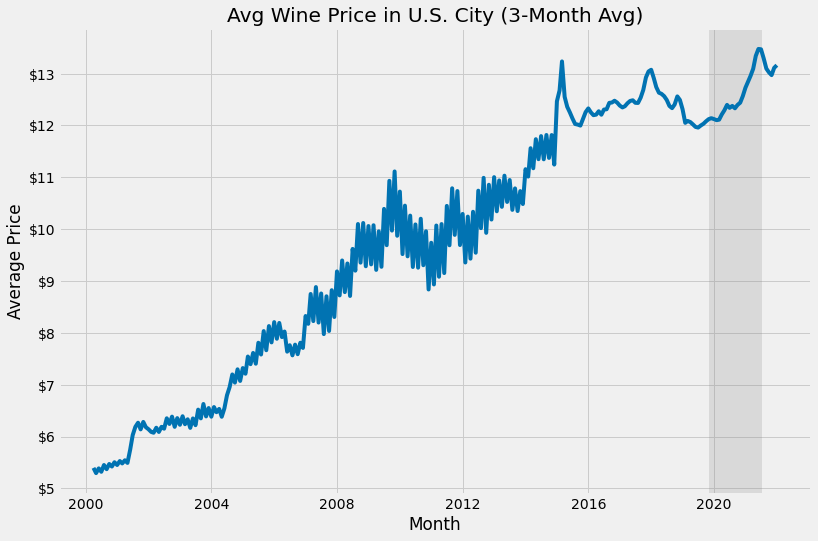

In [13]:
# Convert the additional 25% tariff indicator to a boolean
df['frspger_25'] = df['frspger_25'].astype('bool')

price_line_plot = sns.lineplot(data=df['price'].rolling(3).mean())
price_line_plot.set(title='Avg Wine Price in U.S. City (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_plot.axvspan(
    xmin=df['frspger_25'].where(df['frspger_25']).first_valid_index(), 
    xmax=df['frspger_25'].where(df['frspger_25']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.0f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city.png')
plt.show()

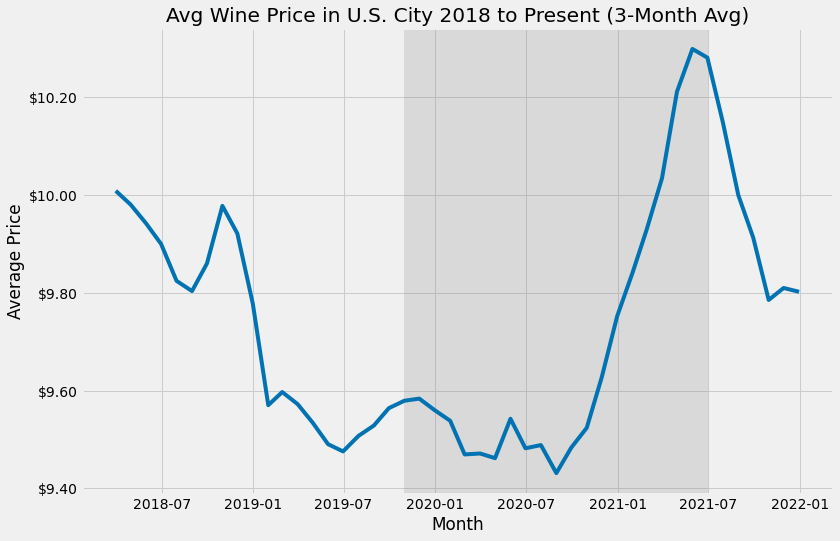

In [14]:
price_line_2018_plot = sns.lineplot(data=df.loc['2018-01-01':'2021-12-31']['price_adj'].rolling(3).mean())
price_line_2018_plot.set(title='Avg Wine Price in U.S. City 2018 to Present (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_2018_plot.axvspan(
    xmin=df['frspger_25'].where(df['frspger_25']).first_valid_index(), 
    xmax=df['frspger_25'].where(df['frspger_25']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_2018_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.2f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city-2018.png')
plt.show()

Alright, let's run the augmented Dickey-Fuller test.

In [15]:
adf(df['price_adj'])

Augmented Dickey-Fuller Test:
t-stat:                   -1.863547
p-value:                   0.349399
lags:                      9.000000
observations:            254.000000
critical value (1%):      -3.456360
critical value (5%):      -2.872987
critical value (10%):     -2.572870
dtype: float64


Since the test statistic is greater than the critical value (at the 5% level), we fail to reject the null hypothesis; the series doesn't have a unit root and is therefore non-stationary.

So I do need to make some adjustments to the series to make it stationary.

<AxesSubplot:xlabel='month', ylabel='price_adj'>

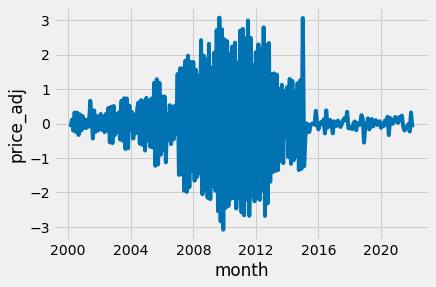

In [16]:
real_price_diff1 = df['price_adj'] - df['price_adj'].shift(1)

sns.lineplot(data=real_price_diff1)

In [17]:
adf(real_price_diff1.dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -8.068729e+00
p-value:                 1.570433e-12
lags:                    8.000000e+00
observations:            2.540000e+02
critical value (1%):    -3.456360e+00
critical value (5%):    -2.872987e+00
critical value (10%):   -2.572870e+00
dtype: float64


It looks like taking the first difference of the data worked to pass the Dickey-Fuller test.

In [18]:
ts_df['price_adj_diff1'] = real_price_diff1

### Domestic Wine Production

#### Bottled

In [19]:
domestic_production_df = df[['bulk', 'bottled', 'cider', 'effervescent', 'population']].copy()
domestic_production_df.head()

,bulk,bottled,cider,effervescent,population
month,,,,,
2000-01-31,1.131505e+08,1.244070e+08,NaN,6.909175e+06,281083000
2000-02-29,7.179357e+07,1.375283e+08,NaN,4.377026e+06,281299000
2000-03-31,4.635628e+07,1.603837e+08,NaN,9.321474e+06,281531000
2000-04-30,3.296724e+07,1.423004e+08,2.045088e+06,7.881046e+06,281763000
2000-05-31,3.178035e+07,1.612658e+08,6.959646e+06,6.334834e+06,281996000


I'm not interested in the distinction between carbonated wines and regular wine or cider and wine. The Alcohol and Tobacco Tax and Trade Bureau (TTB) data had Bottled wine production broken into Still Wine, Cider, and Effervescent. I'm going to subtract out the cider and add in the effervescent wine to the bottled category.

In [20]:
domestic_production_df['bottled_total'] = domestic_production_df['bottled'] - domestic_production_df['cider'] + domestic_production_df['effervescent']

In [131]:
bottled_seasonal_decompose = seasonal_decompose(domestic_production_df['bottled_total'].dropna(), model='multiplicative')

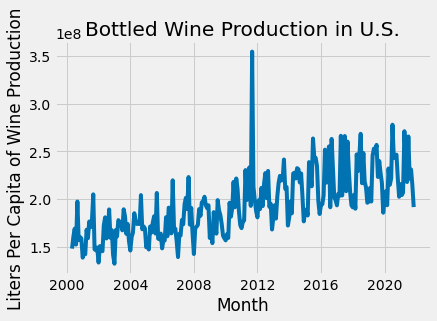

In [132]:
bottled_seas = domestic_production_df['bottled_total'] - bottled_seasonal_decompose.seasonal
bulk_bottled_lineplot = sns.lineplot(data=bottled_seas)
bulk_bottled_lineplot.set(title='Bottled Wine Production in U.S.', xlabel='Month', ylabel='Liters Per Capita of Wine Production')
plt.show()

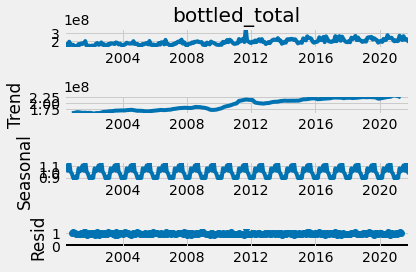

In [135]:
bottled_seasonal_decompose.plot()

plt.show()

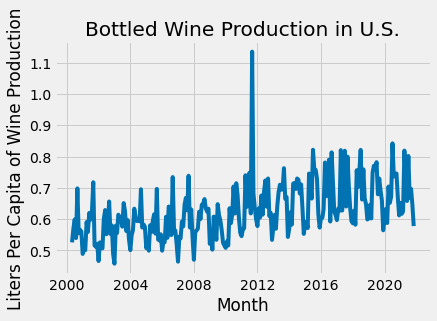

In [21]:
for c in domestic_production_df.columns:
    if c != 'population':
        col_name = c + '_per_capita'
        domestic_production_df[col_name] = domestic_production_df[c] / domestic_production_df['population']

bulk_bottled_lineplot = sns.lineplot(data=domestic_production_df['bottled_total_per_capita'])
bulk_bottled_lineplot.set(title='Bottled Wine Production in U.S.', xlabel='Month', ylabel='Liters Per Capita of Wine Production')
plt.show()

It looks like there's both an upward trend over time and some seasonality. Let's take a first diff and then run the ADF test. If it doesn't pass, let's look closer at the seasonality and then take another diff accordingly.

Augmented Dickey-Fuller Test:
t-stat:                   -4.794225
p-value:                   0.000056
lags:                     14.000000
observations:            243.000000
critical value (1%):      -3.457551
critical value (5%):      -2.873509
critical value (10%):     -2.573148
dtype: float64


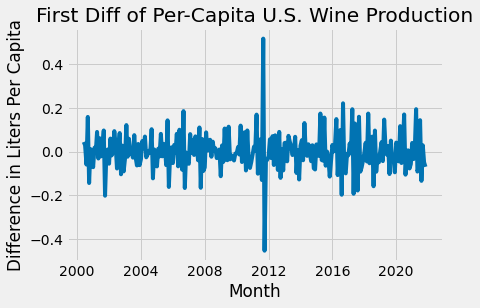

In [22]:
domestic_production_df['bottled_total_per_capita_diff1'] = domestic_production_df['bottled_total_per_capita'] - domestic_production_df['bottled_total_per_capita'].shift(1)
wine_production_bottled_diff_plot = sns.lineplot(data=domestic_production_df['bottled_total_per_capita_diff1'])
wine_production_bottled_diff_plot.set(title='First Diff of Per-Capita U.S. Wine Production', xlabel='Month', ylabel='Difference in Liters Per Capita')

adf(domestic_production_df['bottled_total_per_capita_diff1'].dropna())
plt.show()

Alright, that failed the ADF test.

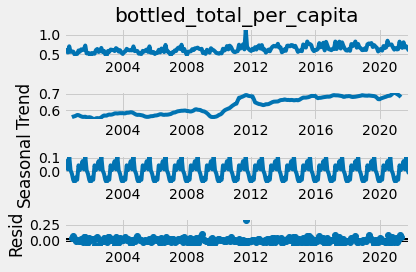

In [23]:
decompose_result_mult = seasonal_decompose(domestic_production_df['bottled_total_per_capita'].dropna(), model='additive') 

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

It definitely looks like there's seasonality in the data. Let's take a closer look at the seasonality to help identify the cycle.

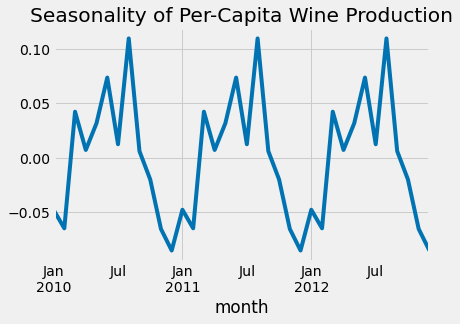

In [24]:
seasonality_bottled_plot = seasonal['2010-01-01':'2013-01-01'].plot()
seasonality_bottled_plot.set(title='Seasonality of Per-Capita Wine Production')
plt.show()

It looks like there's an annual cycle of wine production.

In [25]:
domestic_production_df['bottled_total_per_capita_diff1_diff12'] = domestic_production_df['bottled_total_per_capita_diff1'] - domestic_production_df['bottled_total_per_capita_diff1'].shift(12)

In [26]:
adf(domestic_production_df['bottled_total_per_capita_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.796768e+00
p-value:                 2.290410e-09
lags:                    1.500000e+01
observations:            2.300000e+02
critical value (1%):    -3.459106e+00
critical value (5%):    -2.874190e+00
critical value (10%):   -2.573512e+00
dtype: float64


It looks like taking the second diff worked and we're now passing the ADF test.

In [27]:
ts_df = ts_df.merge(domestic_production_df['bottled_total_per_capita_diff1_diff12'], left_index=True, right_index=True)

#### Bulk Wine

<AxesSubplot:xlabel='month', ylabel='bulk'>

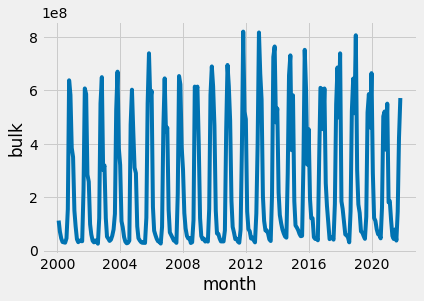

In [28]:
sns.lineplot(data=domestic_production_df['bulk'])

It doesn't really look like there's an upward trend in bulk wine production. But it does look like there's lots of seasonality.

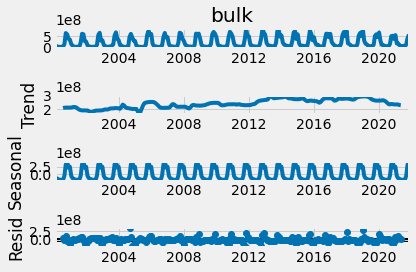

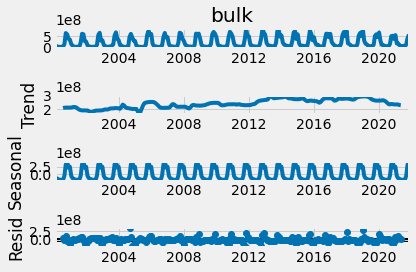

In [29]:
decompose_result_mult = seasonal_decompose(domestic_production_df['bulk'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

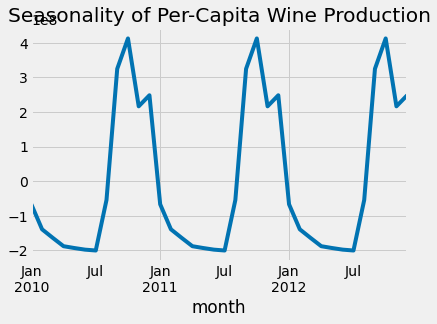

In [30]:
seasonality_bulk_plot = seasonal['2010-01-01':'2013-01-01'].plot()
seasonality_bulk_plot.set(title='Seasonality of Per-Capita Wine Production')
plt.show()

In [31]:
domestic_production_df['bulk_diff12'] = domestic_production_df['bulk'] - domestic_production_df['bulk'].shift(12)
domestic_production_df['bulk_per_capita_diff12'] = domestic_production_df['bulk_per_capita'] - domestic_production_df['bulk_per_capita'].shift(12)

In [32]:
adf(domestic_production_df['bulk_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -5.496346
p-value:                   0.000002
lags:                     12.000000
observations:            237.000000
critical value (1%):      -3.458247
critical value (5%):      -2.873814
critical value (10%):     -2.573311
dtype: float64


In [33]:
adf(domestic_production_df['bulk_per_capita_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -5.662271e+00
p-value:                 9.321169e-07
lags:                    1.200000e+01
observations:            2.370000e+02
critical value (1%):    -3.458247e+00
critical value (5%):    -2.873814e+00
critical value (10%):   -2.573311e+00
dtype: float64


Correcting for the seasonality of bulk wine production allowed the data to pass the ADF test.

In [34]:
ts_df = ts_df.merge(domestic_production_df[['bulk_diff12', 'bulk_per_capita_diff12']], left_index=True, right_index=True)

### Wine Exports

Alright, let's look at the exports data. I think it'll be good to have a variable that's non-basic wine production (wine production that's used for some form of domestic consumption or input). So I'll start by defining a variable for non-basic wine quantity, `nonbasic_quantity`.

In [35]:
df['nonbasic_quantity'] = df['bottled'] - df['cider'] - df['quantity_exports']

So we'll transform `nonbasic_quantity`, `quantity_exports`, and `fas_value_adj_exports` variables to be stationary. And we'll also create per-capita variables for those datapoints.

In [36]:
exports_df = df[['nonbasic_quantity', 'quantity_exports', 'fas_value_adj_exports', 'population']].copy()

In [37]:
for c in exports_df.columns:
    if c != 'population':
        col_name = c + '_per_capita'
        exports_df[col_name] = exports_df[c] / exports_df['population']

#### Non-Basic Wine Production

<AxesSubplot:xlabel='month', ylabel='nonbasic_quantity'>

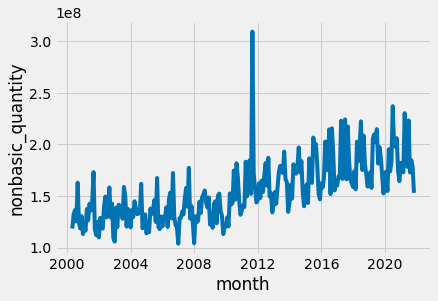

In [38]:
sns.lineplot(data=exports_df['nonbasic_quantity'])

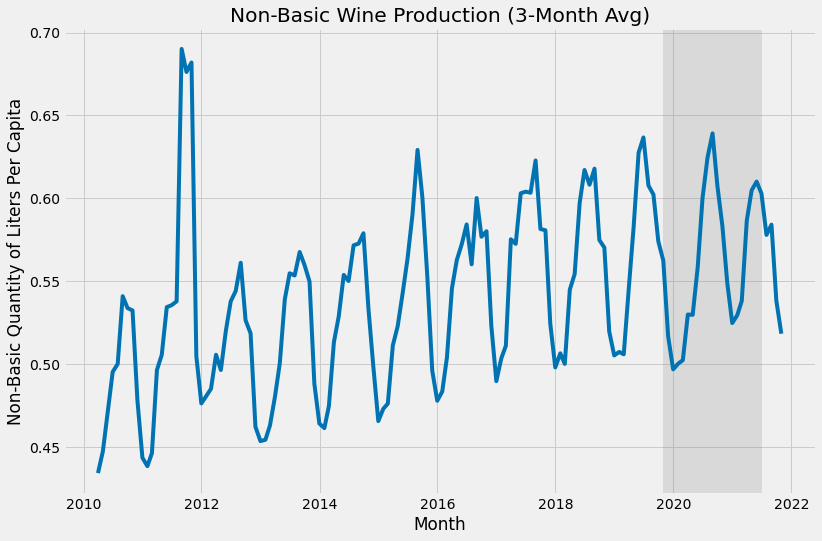

In [39]:
nonbasic_wine_production_plot = sns.lineplot(data=exports_df.loc['2010-01-01':'2021-12-31']['nonbasic_quantity_per_capita'].rolling(3).mean())
nonbasic_wine_production_plot.set(title='Non-Basic Wine Production (3-Month Avg)', ylabel='Non-Basic Quantity of Liters Per Capita', xlabel='Month')
# shade in the timespan of the additional tariff
nonbasic_wine_production_plot.axvspan(
    xmin=df['frspger_25'].where(df['frspger_25']).first_valid_index(), 
    xmax=df['frspger_25'].where(df['frspger_25']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
# nonbasic_wine_production_plot.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{0:g}'.format(x/1e6)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/non-basic-quantity-per-capita-2010.png')
plt.show()

For non-basic wine in the U.S., we see both some seasonality and an upward trend. This makes sense since it includes both bottled and bulk wine production.

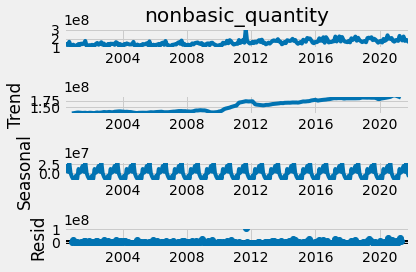

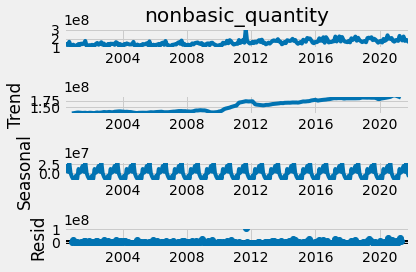

In [40]:
decompose_result_mult = seasonal_decompose(exports_df['nonbasic_quantity'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [41]:
# diff non-basic quantity
exports_df['nonbasic_quantity_diff1'] = exports_df['nonbasic_quantity'] - exports_df['nonbasic_quantity'].shift(1)
exports_df['nonbasic_quantity_diff1_diff12'] = exports_df['nonbasic_quantity_diff1'] - exports_df['nonbasic_quantity_diff1'].shift(12)
# diff non-basic quantity per-capita
exports_df['nonbasic_quantity_per_capita_diff1'] = exports_df['nonbasic_quantity_per_capita'] - exports_df['nonbasic_quantity_per_capita'].shift(1)
exports_df['nonbasic_quantity_per_capita_diff1_diff12'] = exports_df['nonbasic_quantity_per_capita_diff1'] - exports_df['nonbasic_quantity_per_capita_diff1'].shift(12)

In [42]:
adf(exports_df['nonbasic_quantity_diff1_diff12'].dropna())
adf(exports_df['nonbasic_quantity_per_capita_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.669032e+00
p-value:                 4.638129e-09
lags:                    1.500000e+01
observations:            2.300000e+02
critical value (1%):    -3.459106e+00
critical value (5%):    -2.874190e+00
critical value (10%):   -2.573512e+00
dtype: float64
Augmented Dickey-Fuller Test:
t-stat:                 -6.674146e+00
p-value:                 4.509486e-09
lags:                    1.500000e+01
observations:            2.300000e+02
critical value (1%):    -3.459106e+00
critical value (5%):    -2.874190e+00
critical value (10%):   -2.573512e+00
dtype: float64


Alright, so the `nonbasic_quantity_*` variables are passing.

In [43]:
ts_df = ts_df.merge(exports_df[['nonbasic_quantity_diff1_diff12', 'nonbasic_quantity_per_capita_diff1_diff12']], left_index=True, right_index=True)

#### Exports Quantity

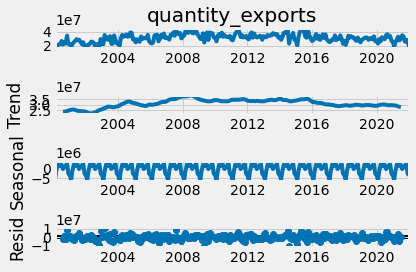

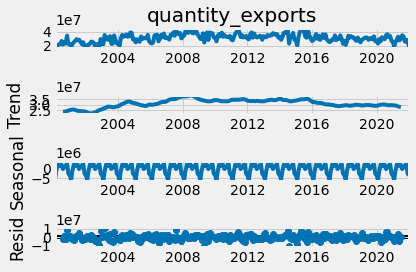

In [44]:
decompose_result_mult = seasonal_decompose(exports_df['quantity_exports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

This looks like there may just be a seasonal trend in it.

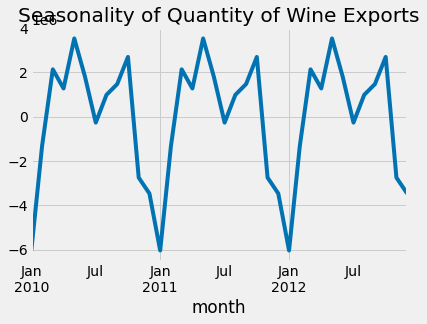

In [45]:
seasonality_bulk_plot = seasonal['2010-01-01':'2013-01-01'].plot()
seasonality_bulk_plot.set(title='Seasonality of Quantity of Wine Exports')
plt.show()

Let's do a 12-month diff and then run the ADF test.

In [46]:
exports_df['quantity_exports_diff12'] = exports_df['quantity_exports'] - exports_df['quantity_exports'].shift(12)
adf(exports_df['quantity_exports_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -4.698711
p-value:                   0.000085
lags:                     12.000000
observations:            239.000000
critical value (1%):      -3.458011
critical value (5%):      -2.873710
critical value (10%):     -2.573256
dtype: float64


Cool, that passes.

In [47]:
ts_df = ts_df.merge(exports_df[['quantity_exports_diff12']], left_index=True, right_index=True)

#### Real FAS Value of Exports

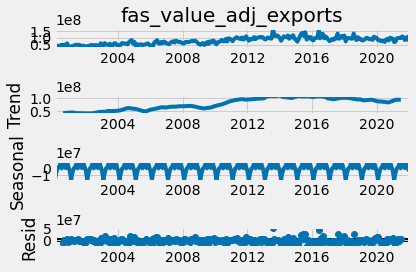

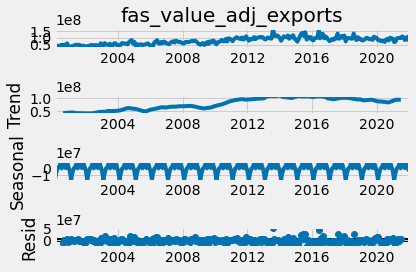

In [48]:
decompose_result_mult = seasonal_decompose(exports_df['fas_value_adj_exports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

It looks like FAS Value has an upward trend and seasonality. From inspection, the seasonality seems to be in a 12-month cycle. So let's just take the diffs and then run the ADF test.

In [49]:
exports_df['fas_value_adj_exports_diff1'] = exports_df['fas_value_adj_exports'] - exports_df['fas_value_adj_exports'].shift(1)
exports_df['fas_value_adj_exports_diff1_diff12'] = exports_df['fas_value_adj_exports_diff1'] - exports_df['fas_value_adj_exports_diff1'].shift(12)
adf(exports_df['fas_value_adj_exports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.410001e+00
p-value:                 1.901197e-08
lags:                    1.600000e+01
observations:            2.340000e+02
critical value (1%):    -3.458608e+00
critical value (5%):    -2.873972e+00
critical value (10%):   -2.573396e+00
dtype: float64


That worked.

In [50]:
ts_df = ts_df.merge(exports_df['fas_value_adj_exports_diff1_diff12'], left_index=True, right_index=True)

### Imports

Now we'll adjust imports for stationarity. It may be good to add a variable that represents the percentage of world totals that are affected by the additional tariffs. So I'll do that first and also adjust for per-capita values.

In [51]:
imports_df = df[['dutiable_value_world_imports',
    'dutiable_value_adj_world_imports',
    'landed_duty_paid_value_world_imports',
    'landed_duty_paid_value_adj_world_imports',
    'customs_value_world_imports', 'customs_value_adj_world_imports',
    'quantity_world_imports', 'charges_insurance_freight_world_imports',
    'charges_insurance_freight_adj_world_imports',
    'calculated_duties_world_imports',
    'calculated_duties_adj_world_imports',
    'dutiable_value_ukfrspde_imports',
    'dutiable_value_adj_ukfrspde_imports',
    'landed_duty_paid_value_ukfrspde_imports',
    'landed_duty_paid_value_adj_ukfrspde_imports',
    'customs_value_ukfrspde_imports', 'customs_value_adj_ukfrspde_imports',
    'quantity_ukfrspde_imports',
    'charges_insurance_freight_ukfrspde_imports',
    'charges_insurance_freight_adj_ukfrspde_imports',
    'calculated_duties_ukfrspde_imports',
    'calculated_duties_adj_ukfrspde_imports', 'population']].copy()

# Proportion of imports' values provided by UK, Fr, Sp, and De
imports_df['dutiable_value_ukfrspde_proportion_imports'] = imports_df['dutiable_value_adj_ukfrspde_imports'] / imports_df['dutiable_value_adj_world_imports']
imports_df['landed_duty_paid_ukfrspde_proportion_imports'] = imports_df['landed_duty_paid_value_adj_ukfrspde_imports'] / imports_df['landed_duty_paid_value_adj_world_imports']
imports_df['customs_value_ukfrspde_proportion_imports'] = imports_df['customs_value_adj_ukfrspde_imports'] / imports_df['customs_value_adj_world_imports']
imports_df['quantity_ukfrspde_proportion_imports'] = imports_df['quantity_ukfrspde_imports'] / imports_df['quantity_world_imports']
imports_df['charges_insurance_freight_ukfrspde_proportion_imports'] = imports_df['charges_insurance_freight_adj_ukfrspde_imports'] / imports_df['charges_insurance_freight_adj_world_imports']
imports_df['calculated_duties_ukfrspde_proportion_imports'] = imports_df['calculated_duties_adj_ukfrspde_imports'] / imports_df['calculated_duties_adj_world_imports']

# Per-capita quantities of wine imports
imports_df['quantity_world_per_capita_imports'] = imports_df['quantity_world_imports'] / imports_df['population']
imports_df['quantity_ukfrspde_per_capita_imports'] = imports_df['quantity_ukfrspde_imports'] / imports_df['population']

# Incorporate new fields into original dataframe
df['dutiable_value_ukfrspde_proportion_imports'] = imports_df['dutiable_value_ukfrspde_proportion_imports']
df['landed_duty_paid_ukfrspde_proportion_imports'] = imports_df['landed_duty_paid_ukfrspde_proportion_imports']
df['customs_value_ukfrspde_proportion_imports'] = imports_df['customs_value_ukfrspde_proportion_imports']
df['quantity_ukfrspde_proportion_imports'] = imports_df['quantity_ukfrspde_proportion_imports']
df['charges_insurance_freight_ukfrspde_proportion_imports'] = imports_df['charges_insurance_freight_ukfrspde_proportion_imports']
df['calculated_duties_ukfrspde_proportion_imports'] = imports_df['calculated_duties_ukfrspde_proportion_imports']
df['quantity_world_per_capita_imports'] = imports_df['quantity_world_per_capita_imports']
df['quantity_ukfrspde_per_capita_imports'] = imports_df['quantity_ukfrspde_per_capita_imports']

#### U.K., France, Spain, Germany

In [52]:
cols = []
for c in imports_df.columns:
    if 'ukfrspde' in c:
        cols.append(c)

imports_subset1_df = imports_df[cols].copy()

In [53]:
imports_subset1_df = imports_subset1_df[['customs_value_adj_ukfrspde_imports', 'calculated_duties_adj_ukfrspde_imports', 
    'charges_insurance_freight_adj_ukfrspde_imports', 'quantity_ukfrspde_imports', 
    'quantity_ukfrspde_proportion_imports', 'quantity_ukfrspde_per_capita_imports']]

##### Customs Value

In [54]:
adf(imports_subset1_df['customs_value_adj_ukfrspde_imports'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -1.522449
p-value:                   0.522378
lags:                     13.000000
observations:            250.000000
critical value (1%):      -3.456781
critical value (5%):      -2.873172
critical value (10%):     -2.572969
dtype: float64


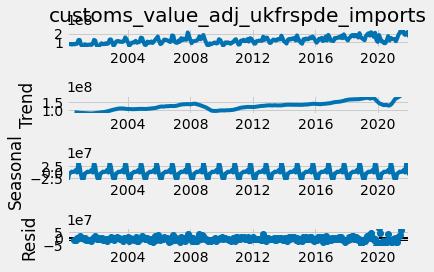

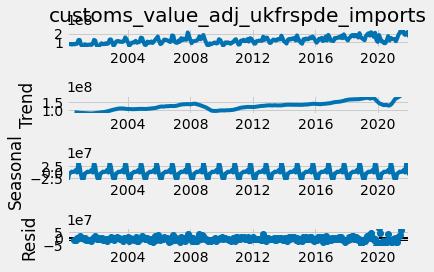

In [55]:
decompose_result_mult = seasonal_decompose(imports_subset1_df['customs_value_adj_ukfrspde_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [56]:
imports_subset1_df['customs_value_adj_ukfrspde_imports_diff1'] = imports_subset1_df['customs_value_adj_ukfrspde_imports'] - imports_subset1_df['customs_value_adj_ukfrspde_imports'].shift(1)
imports_subset1_df['customs_value_adj_ukfrspde_imports_diff1_diff12'] = imports_subset1_df['customs_value_adj_ukfrspde_imports_diff1'] - imports_subset1_df['customs_value_adj_ukfrspde_imports_diff1'].shift(12)
adf(imports_subset1_df['customs_value_adj_ukfrspde_imports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -7.935206e+00
p-value:                 3.428209e-12
lags:                    1.300000e+01
observations:            2.370000e+02
critical value (1%):    -3.458247e+00
critical value (5%):    -2.873814e+00
critical value (10%):   -2.573311e+00
dtype: float64


In [57]:
ts_df = ts_df.merge(imports_subset1_df['customs_value_adj_ukfrspde_imports_diff1_diff12'], left_index=True, right_index=True)

##### Calculated Duties

In [58]:
adf(imports_subset1_df['calculated_duties_adj_ukfrspde_imports'])

Augmented Dickey-Fuller Test:
t-stat:                   -3.654396
p-value:                   0.004802
lags:                     15.000000
observations:            248.000000
critical value (1%):      -3.456996
critical value (5%):      -2.873266
critical value (10%):     -2.573019
dtype: float64


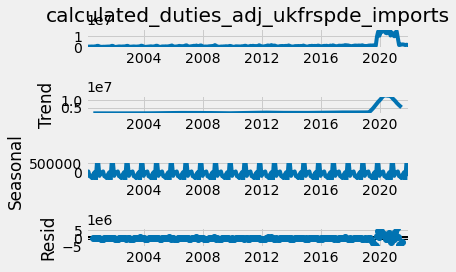

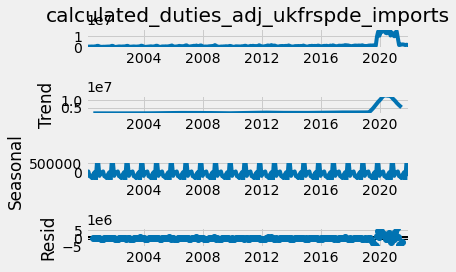

In [59]:
decompose_result_mult = seasonal_decompose(imports_subset1_df['calculated_duties_adj_ukfrspde_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [60]:
imports_subset1_df['calculated_duties_adj_ukfrspde_imports_diff1'] = imports_subset1_df['calculated_duties_adj_ukfrspde_imports'] - imports_subset1_df['calculated_duties_adj_ukfrspde_imports'].shift(1)
imports_subset1_df['calculated_duties_adj_ukfrspde_imports_diff1_diff12'] = imports_subset1_df['calculated_duties_adj_ukfrspde_imports_diff1'] - imports_subset1_df['calculated_duties_adj_ukfrspde_imports_diff1'].shift(12)
adf(imports_subset1_df['calculated_duties_adj_ukfrspde_imports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -5.431072
p-value:                   0.000003
lags:                     16.000000
observations:            234.000000
critical value (1%):      -3.458608
critical value (5%):      -2.873972
critical value (10%):     -2.573396
dtype: float64


In [61]:
ts_df = ts_df.merge(imports_subset1_df['calculated_duties_adj_ukfrspde_imports_diff1_diff12'], left_index=True, right_index=True)

##### Charges, Insurance, and Freight

In [62]:
adf(imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports'])

Augmented Dickey-Fuller Test:
t-stat:                   -1.451255
p-value:                   0.557473
lags:                     13.000000
observations:            250.000000
critical value (1%):      -3.456781
critical value (5%):      -2.873172
critical value (10%):     -2.572969
dtype: float64


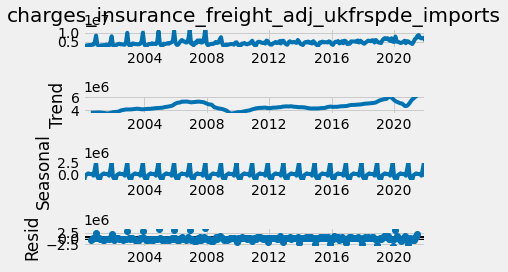

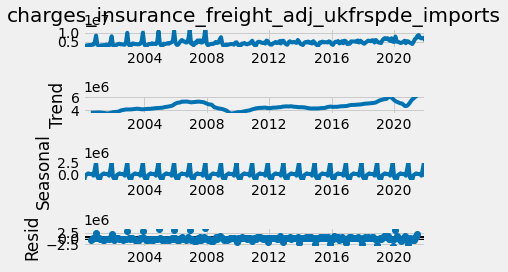

In [63]:
decompose_result_mult = seasonal_decompose(imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [64]:
imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports_diff1'] = imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports'] - imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports'].shift(1)
imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12'] = imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports_diff1'] - imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports_diff1'].shift(12)
adf(imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.201207e+00
p-value:                 5.801371e-08
lags:                    1.600000e+01
observations:            2.340000e+02
critical value (1%):    -3.458608e+00
critical value (5%):    -2.873972e+00
critical value (10%):   -2.573396e+00
dtype: float64


In [65]:
ts_df = ts_df.merge(imports_subset1_df['charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12'], left_index=True, right_index=True)

##### Quantity

In [66]:
adf(imports_subset1_df['quantity_ukfrspde_imports'])

Augmented Dickey-Fuller Test:
t-stat:                   -0.436341
p-value:                   0.903852
lags:                     13.000000
observations:            250.000000
critical value (1%):      -3.456781
critical value (5%):      -2.873172
critical value (10%):     -2.572969
dtype: float64


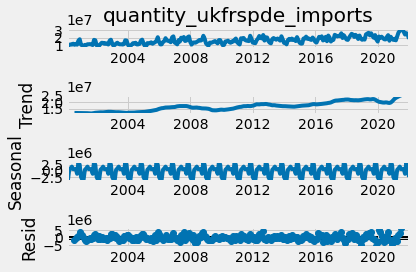

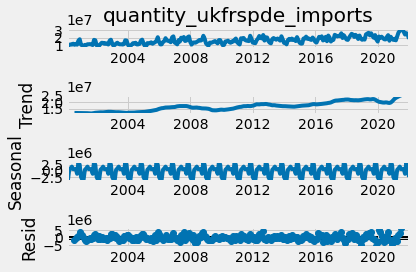

In [67]:
decompose_result_mult = seasonal_decompose(imports_subset1_df['quantity_ukfrspde_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [68]:
imports_subset1_df['quantity_ukfrspde_imports_diff1'] = imports_subset1_df['quantity_ukfrspde_imports'] - imports_subset1_df['quantity_ukfrspde_imports'].shift(1)
imports_subset1_df['quantity_ukfrspde_imports_diff1_diff12'] = imports_subset1_df['quantity_ukfrspde_imports_diff1'] - imports_subset1_df['quantity_ukfrspde_imports_diff1'].shift(12)
adf(imports_subset1_df['quantity_ukfrspde_imports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.424159e+00
p-value:                 1.761400e-08
lags:                    1.300000e+01
observations:            2.370000e+02
critical value (1%):    -3.458247e+00
critical value (5%):    -2.873814e+00
critical value (10%):   -2.573311e+00
dtype: float64


In [69]:
ts_df = ts_df.merge(imports_subset1_df['quantity_ukfrspde_imports_diff1_diff12'], left_index=True, right_index=True)

##### Quantity as a Proportion of World Imports

In [70]:
adf(imports_subset1_df['quantity_ukfrspde_proportion_imports'])

Augmented Dickey-Fuller Test:
t-stat:                   -2.784062
p-value:                   0.060587
lags:                     13.000000
observations:            250.000000
critical value (1%):      -3.456781
critical value (5%):      -2.873172
critical value (10%):     -2.572969
dtype: float64


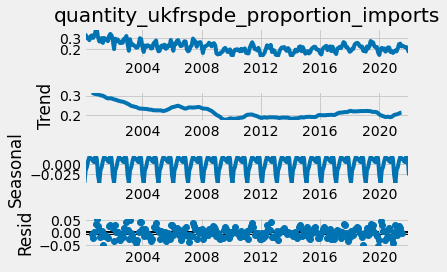

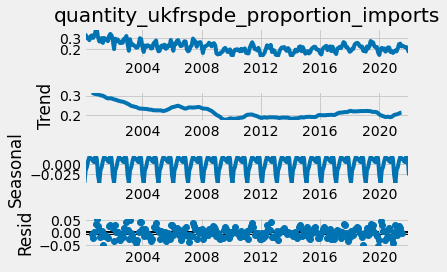

In [71]:
decompose_result_mult = seasonal_decompose(imports_subset1_df['quantity_ukfrspde_proportion_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [72]:
imports_subset1_df['quantity_ukfrspde_proportion_imports_diff12'] = imports_subset1_df['quantity_ukfrspde_proportion_imports'] - imports_subset1_df['quantity_ukfrspde_proportion_imports'].shift(12)
adf(imports_subset1_df['quantity_ukfrspde_proportion_imports_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -3.105613
p-value:                   0.026141
lags:                     13.000000
observations:            238.000000
critical value (1%):      -3.458128
critical value (5%):      -2.873762
critical value (10%):     -2.573283
dtype: float64


In [73]:
imports_subset1_df['quantity_ukfrspde_proportion_imports_diff12_diff1'] = imports_subset1_df['quantity_ukfrspde_proportion_imports_diff12'] - imports_subset1_df['quantity_ukfrspde_proportion_imports_diff12'].shift(1)
adf(imports_subset1_df['quantity_ukfrspde_proportion_imports_diff12_diff1'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.683635e+00
p-value:                 4.280055e-09
lags:                    1.300000e+01
observations:            2.370000e+02
critical value (1%):    -3.458247e+00
critical value (5%):    -2.873814e+00
critical value (10%):   -2.573311e+00
dtype: float64


In [74]:
ts_df = ts_df.merge(imports_subset1_df['quantity_ukfrspde_proportion_imports_diff12_diff1'], left_index=True, right_index=True)

##### Quantity Per Capita

In [75]:
adf(imports_subset1_df['quantity_ukfrspde_per_capita_imports'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -0.763268
p-value:                   0.829674
lags:                     13.000000
observations:            250.000000
critical value (1%):      -3.456781
critical value (5%):      -2.873172
critical value (10%):     -2.572969
dtype: float64


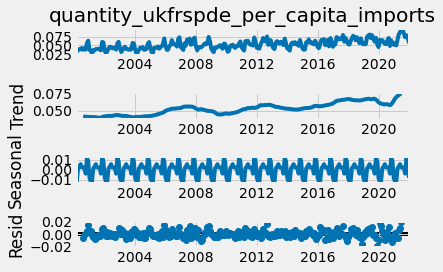

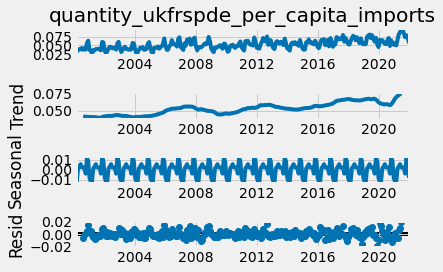

In [76]:
decompose_result_mult = seasonal_decompose(imports_subset1_df['quantity_ukfrspde_per_capita_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [77]:
imports_subset1_df['quantity_ukfrspde_per_capita_imports_diff1'] = imports_subset1_df['quantity_ukfrspde_per_capita_imports'] - imports_subset1_df['quantity_ukfrspde_per_capita_imports'].shift(1)
imports_subset1_df['quantity_ukfrspde_per_capita_imports_diff1_diff12'] = imports_subset1_df['quantity_ukfrspde_per_capita_imports_diff1'] - imports_subset1_df['quantity_ukfrspde_per_capita_imports_diff1'].shift(12)
adf(imports_subset1_df['quantity_ukfrspde_per_capita_imports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.326419e+00
p-value:                 2.978744e-08
lags:                    1.300000e+01
observations:            2.370000e+02
critical value (1%):    -3.458247e+00
critical value (5%):    -2.873814e+00
critical value (10%):   -2.573311e+00
dtype: float64


In [78]:
ts_df = ts_df.merge(imports_subset1_df['quantity_ukfrspde_per_capita_imports_diff1_diff12'], left_index=True, right_index=True)

#### World

In [79]:
cols = []
for c in imports_df.columns:
    if 'world' in c:
        cols.append(c)

imports_subset2_df = imports_df[cols].copy()

In [80]:
imports_subset2_df = imports_subset2_df[['customs_value_adj_world_imports', 'calculated_duties_adj_world_imports', 
    'charges_insurance_freight_adj_world_imports', 'quantity_world_imports', 'quantity_world_per_capita_imports']]

##### Customs Value

In [81]:
adf(imports_subset2_df['customs_value_adj_world_imports'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -1.459830
p-value:                   0.553281
lags:                     13.000000
observations:            250.000000
critical value (1%):      -3.456781
critical value (5%):      -2.873172
critical value (10%):     -2.572969
dtype: float64


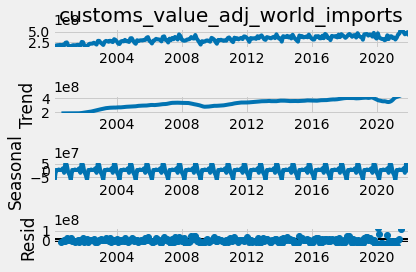

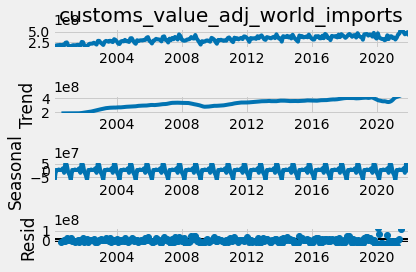

In [82]:
decompose_result_mult = seasonal_decompose(imports_subset2_df['customs_value_adj_world_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [83]:
imports_subset2_df['customs_value_adj_world_imports_diff1'] = imports_subset2_df['customs_value_adj_world_imports'] - imports_subset2_df['customs_value_adj_world_imports'].shift(1)
imports_subset2_df['customs_value_adj_world_imports_diff1_diff12'] = imports_subset2_df['customs_value_adj_world_imports_diff1'] - imports_subset2_df['customs_value_adj_world_imports_diff1'].shift(12)
adf(imports_subset2_df['customs_value_adj_world_imports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.834680e+00
p-value:                 1.855488e-09
lags:                    1.300000e+01
observations:            2.370000e+02
critical value (1%):    -3.458247e+00
critical value (5%):    -2.873814e+00
critical value (10%):   -2.573311e+00
dtype: float64


In [84]:
ts_df = ts_df.merge(imports_subset2_df['customs_value_adj_world_imports_diff1_diff12'], left_index=True, right_index=True)

##### Calculated Duties

In [85]:
adf(imports_subset2_df['calculated_duties_adj_world_imports'])

Augmented Dickey-Fuller Test:
t-stat:                   -3.584811
p-value:                   0.006058
lags:                     12.000000
observations:            251.000000
critical value (1%):      -3.456674
critical value (5%):      -2.873125
critical value (10%):     -2.572944
dtype: float64


In [86]:
ts_df = ts_df.merge(imports_subset2_df['calculated_duties_adj_world_imports'], left_index=True, right_index=True)

##### Charges, Insurance, and Freight

In [87]:
adf(imports_subset2_df['charges_insurance_freight_adj_world_imports'])

Augmented Dickey-Fuller Test:
t-stat:                   -2.183202
p-value:                   0.212398
lags:                     16.000000
observations:            247.000000
critical value (1%):      -3.457105
critical value (5%):      -2.873314
critical value (10%):     -2.573044
dtype: float64


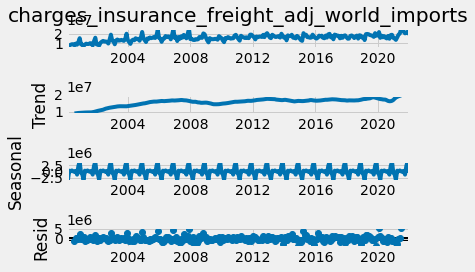

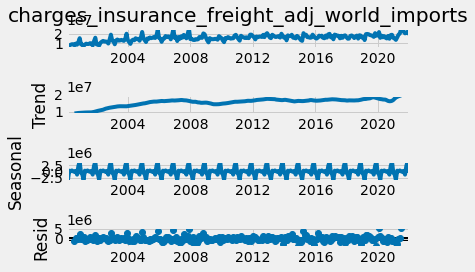

In [88]:
decompose_result_mult = seasonal_decompose(imports_subset2_df['charges_insurance_freight_adj_world_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [89]:
imports_subset2_df['charges_insurance_freight_adj_world_imports_diff1'] = imports_subset2_df['charges_insurance_freight_adj_world_imports'] - imports_subset2_df['charges_insurance_freight_adj_world_imports'].shift(1)
imports_subset2_df['charges_insurance_freight_adj_world_imports_diff1_diff12'] = imports_subset2_df['charges_insurance_freight_adj_world_imports_diff1'] - imports_subset2_df['charges_insurance_freight_adj_world_imports_diff1'].shift(12)
adf(imports_subset2_df['charges_insurance_freight_adj_world_imports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.190991e+00
p-value:                 6.123570e-08
lags:                    1.600000e+01
observations:            2.340000e+02
critical value (1%):    -3.458608e+00
critical value (5%):    -2.873972e+00
critical value (10%):   -2.573396e+00
dtype: float64


In [90]:
ts_df = ts_df.merge(imports_subset2_df['charges_insurance_freight_adj_world_imports_diff1_diff12'], left_index=True, right_index=True)

##### Quantity

In [91]:
adf(imports_subset2_df['quantity_world_imports'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -0.665185
p-value:                   0.855563
lags:                     13.000000
observations:            250.000000
critical value (1%):      -3.456781
critical value (5%):      -2.873172
critical value (10%):     -2.572969
dtype: float64


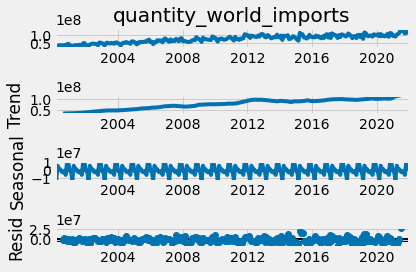

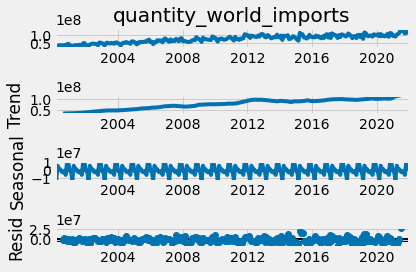

In [92]:
decompose_result_mult = seasonal_decompose(imports_subset2_df['quantity_world_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [93]:
imports_subset2_df['quantity_world_imports_diff1'] = imports_subset2_df['quantity_world_imports'] - imports_subset2_df['quantity_world_imports'].shift(1)
imports_subset2_df['quantity_world_imports_diff1_diff12'] = imports_subset2_df['quantity_world_imports_diff1'] - imports_subset2_df['quantity_world_imports_diff1'].shift(12)
adf(imports_subset2_df['quantity_world_imports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.029991e+00
p-value:                 1.425555e-07
lags:                    1.600000e+01
observations:            2.340000e+02
critical value (1%):    -3.458608e+00
critical value (5%):    -2.873972e+00
critical value (10%):   -2.573396e+00
dtype: float64


In [94]:
ts_df = ts_df.merge(imports_subset2_df['quantity_world_imports_diff1_diff12'], left_index=True, right_index=True)

##### Quantity Per Capita

In [95]:
adf(imports_subset2_df['quantity_world_per_capita_imports'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                   -0.972273
p-value:                   0.763242
lags:                     13.000000
observations:            250.000000
critical value (1%):      -3.456781
critical value (5%):      -2.873172
critical value (10%):     -2.572969
dtype: float64


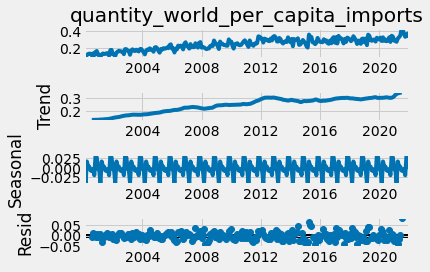

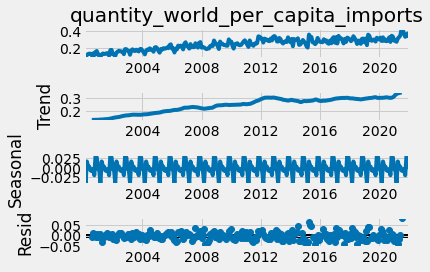

In [96]:
decompose_result_mult = seasonal_decompose(imports_subset2_df['quantity_world_per_capita_imports'].dropna(), model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

In [97]:
imports_subset2_df['quantity_world_per_capita_imports_diff1'] = imports_subset2_df['quantity_world_per_capita_imports'] - imports_subset2_df['quantity_world_per_capita_imports'].shift(1)
imports_subset2_df['quantity_world_per_capita_imports_diff1_diff12'] = imports_subset2_df['quantity_world_per_capita_imports_diff1'] - imports_subset2_df['quantity_world_per_capita_imports_diff1'].shift(12)
adf(imports_subset2_df['quantity_world_per_capita_imports_diff1_diff12'].dropna())

Augmented Dickey-Fuller Test:
t-stat:                 -6.062868e+00
p-value:                 1.200914e-07
lags:                    1.600000e+01
observations:            2.340000e+02
critical value (1%):    -3.458608e+00
critical value (5%):    -2.873972e+00
critical value (10%):   -2.573396e+00
dtype: float64


In [98]:
ts_df = ts_df.merge(imports_subset2_df['quantity_world_per_capita_imports_diff1_diff12'], left_index=True, right_index=True)

Now we've made everything stationary for the multivariate time series.

In [99]:
display(ts_df.dropna().head())

,frspger_25,price_adj_diff1,bottled_total_per_capita_diff1_diff12,bulk_diff12,bulk_per_capita_diff12,nonbasic_quantity_diff1_diff12,nonbasic_quantity_per_capita_diff1_diff12,quantity_exports_diff12,fas_value_adj_exports_diff1_diff12,customs_value_adj_ukfrspde_imports_diff1_diff12,calculated_duties_adj_ukfrspde_imports_diff1_diff12,charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12,quantity_ukfrspde_imports_diff1_diff12,quantity_ukfrspde_proportion_imports_diff12_diff1,quantity_ukfrspde_per_capita_imports_diff1_diff12,customs_value_adj_world_imports_diff1_diff12,calculated_duties_adj_world_imports,charges_insurance_freight_adj_world_imports_diff1_diff12,quantity_world_imports_diff1_diff12,quantity_world_per_capita_imports_diff1_diff12
month,,,,,,,,,,,,,,,,,,,,
2001-05-31,0,0.659528,0.016915,6.595232e+06,0.022032,2.428998e+06,0.008028,7204114.0,1.040327e+06,8.508741e+06,176039.000669,189967.702126,1441077.0,0.060835,0.005072,-7.017318e+06,2.579096e+06,-8.889423e+05,-3193275.0,-0.011262
2001-06-30,0,0.242013,-0.050785,5.953839e+06,0.019816,-1.053018e+07,-0.037087,998658.0,-7.739911e+06,-5.426225e+06,-75155.816947,-283322.796341,-1241802.0,-0.040281,-0.004398,2.364912e+05,2.717220e+06,1.200196e+03,1031146.0,0.003642
2001-07-31,0,-0.434246,0.082204,-1.084195e+07,-0.039632,1.902590e+07,0.067087,7048878.0,8.425537e+06,7.139594e+06,122605.114091,565432.829575,1692652.0,-0.018479,0.005988,2.828532e+07,2.990120e+06,1.895395e+06,7704403.0,0.027200
2001-08-31,0,0.380452,-0.062038,7.302612e+07,0.250287,-8.521039e+06,-0.031190,295126.0,-1.252128e+07,-1.061431e+07,-192850.754169,-609574.553977,-1839244.0,0.011007,-0.006486,-3.052870e+07,2.938348e+06,-2.047266e+06,-7049077.0,-0.024939
2001-09-30,0,-0.242006,-0.058162,-3.044768e+07,-0.128668,-1.687791e+07,-0.057719,-992607.0,-1.852250e+06,1.310284e+07,63825.896916,-297341.446600,432505.0,0.027586,0.001558,5.153565e+06,2.574896e+06,-9.266976e+05,-2195867.0,-0.007474


### Johansen Test

In [100]:
johan_test_df = ts_df[['price_adj_diff1',
    'nonbasic_quantity_diff1_diff12',
    'fas_value_adj_exports_diff1_diff12', 
    'quantity_ukfrspde_proportion_imports_diff12_diff1', 
    'calculated_duties_adj_world_imports', 
    'charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12',
    'quantity_world_per_capita_imports_diff1_diff12',
    'frspger_25'
    ]]

In [101]:
johan_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2000-01-31 to 2021-12-31
Data columns (total 8 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   price_adj_diff1                                              263 non-null    float64
 1   nonbasic_quantity_diff1_diff12                               246 non-null    float64
 2   fas_value_adj_exports_diff1_diff12                           251 non-null    float64
 3   quantity_ukfrspde_proportion_imports_diff12_diff1            251 non-null    float64
 4   calculated_duties_adj_world_imports                          264 non-null    float64
 5   charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12  251 non-null    float64
 6   quantity_world_per_capita_imports_diff1_diff12               251 non-null    float64
 7   frspger_25                                                   2

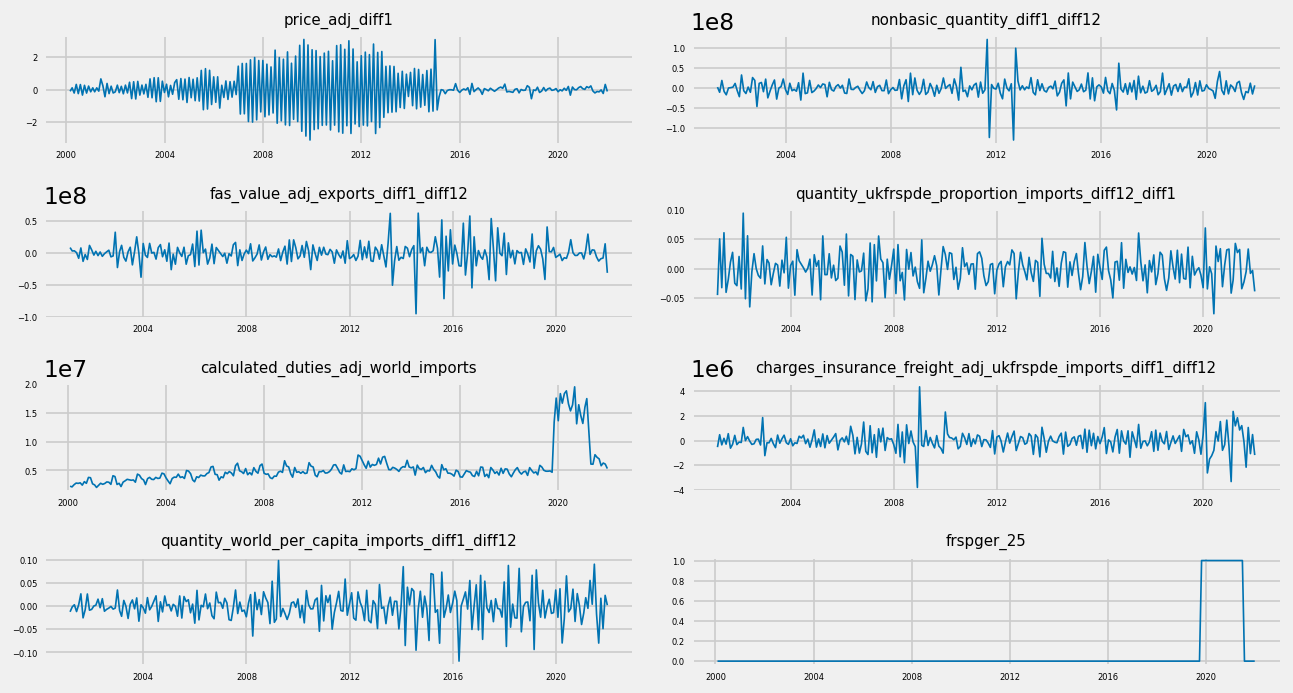

In [102]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(11,6))
for i, ax in enumerate(axes.flatten()):
    data = johan_test_df[johan_test_df.columns[i]]
    ax.plot(data, linewidth=1)

    ax.set_title(johan_test_df.columns[i], size=9)
    ax.tick_params(labelsize=5)

plt.tight_layout()
plt.show()

Let's define a function that provides a printout of the results of a cointegration johansen test of the variables for our analysis.

In [103]:
def johansen_test(var_df, critical_value=0.05): 
    output = coint_johansen(var_df, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    trace_stat = output.lr1
    critical_values = output.cvt[:, d[str(1-critical_value)]]

    print('Cointegration Johansen Test:')
    print('{:<62}'.format('Variable') + '{:<30}'.format('T-Stat > Critical Values') + '{:<20}'.format('Significant'))
    print('--'*52)
    for col, trace, cvt in zip(var_df.columns, trace_stat, critical_values):
        print('{:<62}'.format(col) + '{:<30}'.format('{:<7}'.format(format(trace, '.3f')) + ' > ' + '{:<7}'.format(format(cvt, '.3f'))) + '{:<20}'.format(str(trace > cvt)))

In [104]:
# drop boolean datapoint
johan_test_df = johan_test_df.drop(columns=['frspger_25'])

johansen_test(johan_test_df.dropna())

Cointegration Johansen Test:
Variable                                                      T-Stat > Critical Values      Significant         
--------------------------------------------------------------------------------------------------------
price_adj_diff1                                               467.573 > 111.780             True                
nonbasic_quantity_diff1_diff12                                352.348 > 83.938              True                
fas_value_adj_exports_diff1_diff12                            256.515 > 60.063              True                
quantity_ukfrspde_proportion_imports_diff12_diff1             162.657 > 40.175              True                
calculated_duties_adj_world_imports                           104.444 > 24.276              True                
charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12   52.150  > 12.321              True                
quantity_world_per_capita_imports_diff1_diff12                1.223   > 4.1

## Modeling

Before modeling, we need to do a train-test split to be able to forecast on the data. I should have done this much earlier on and used only the training data for checking for stationarity and granger causality. However, we're here now. New data will be published soon and we'll be able to incorporate that into the a new test set. For now, let's just pull out the most recent few observations for the test set (the most recent 3 months of data).

In [105]:
obs = 3
ts_train, ts_test = johan_test_df.dropna()[0:-obs], johan_test_df.dropna()[-obs:]

In [106]:
ts_train

,price_adj_diff1,nonbasic_quantity_diff1_diff12,fas_value_adj_exports_diff1_diff12,quantity_ukfrspde_proportion_imports_diff12_diff1,calculated_duties_adj_world_imports,charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12,quantity_world_per_capita_imports_diff1_diff12
month,,,,,,,
2001-05-31,0.659528,2.428998e+06,1.040327e+06,0.060835,2.579096e+06,1.899677e+05,-0.011262
2001-06-30,0.242013,-1.053018e+07,-7.739911e+06,-0.040281,2.717220e+06,-2.833228e+05,0.003642
2001-07-31,-0.434246,1.902590e+07,8.425537e+06,-0.018479,2.990120e+06,5.654328e+05,0.027200
2001-08-31,0.380452,-8.521039e+06,-1.252128e+07,0.011007,2.938348e+06,-6.095746e+05,-0.024939
2001-09-30,-0.242006,-1.687791e+07,-1.852250e+06,0.027586,2.574896e+06,-2.973414e+05,-0.007474
...,...,...,...,...,...,...,...
2021-03-31,0.115665,1.685490e+07,3.008267e+07,0.042747,1.160764e+07,1.199310e+06,-0.004261
2021-04-30,0.230637,-1.143297e+07,-1.641979e+06,0.027219,6.101831e+06,1.861444e+06,0.056351
2021-05-31,-0.083969,-2.850532e+07,5.475490e+06,0.032440,6.080915e+06,8.662714e+05,0.004597


### Lag Order Selection

In [107]:
model = VAR(ts_train)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [108]:
lag_orders = model.select_order(maxlags=12)
lag_orders.summary()

,AIC,BIC,FPE,HQIC
0,110.5,110.6,9.647e+47,110.5
1,105.0,105.8*,4.046e+45,105.4*
2,104.8,106.3,3.135e+45,105.4
3,104.7,107.0,3.094e+45,105.7
4,104.8,107.8,3.297e+45,106.0
5,104.9,108.6,3.627e+45,106.4
6,104.9,109.4,3.905e+45,106.8
7,105.0,110.2,4.155e+45,107.1
8,105.0,110.9,4.173e+45,107.4
9,105.1,111.8,5.029e+45,107.8


It looks like the recommendation is for a lag order of 1. Let's go with that.

### Fit the Model

In [109]:
tsmf = model.fit(3)
tsmf.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Mar, 2022
Time:                     16:26:18
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    106.850
Nobs:                     240.000    HQIC:                   105.517
Log likelihood:          -14783.8    FPE:                2.72968e+45
AIC:                      104.617    Det(Omega_mle):     1.47734e+45
--------------------------------------------------------------------
Results for equation price_adj_diff1
                                                                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------------
const                                                                  0.015077         0.042793            0.352 

### Test Causality

In [110]:
f_test_res = tsmf.test_causality('price_adj_diff1', ['nonbasic_quantity_diff1_diff12', 'fas_value_adj_exports_diff1_diff12', 'quantity_ukfrspde_proportion_imports_diff12_diff1', 'calculated_duties_adj_world_imports', 'charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12', 'quantity_world_per_capita_imports_diff1_diff12'], kind='f')
print(f_test_res)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ['nonbasic_quantity_diff1_diff12', 'fas_value_adj_exports_diff1_diff12', 'quantity_ukfrspde_proportion_imports_diff12_diff1', 'calculated_duties_adj_world_imports', 'charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12', 'quantity_world_per_capita_imports_diff1_diff12'] do not Granger-cause price_adj_diff1: fail to reject at 5% significance level. Test statistic: 0.666, critical value: 1.611>, p-value: 0.847>


In [111]:
stable = tsmf.is_stable

In [112]:
print(stable)

<bound method VARProcess.is_stable of <statsmodels.tsa.vector_ar.var_model.VARResults object at 0x7fee20bdc610>>


### Serial Correlation of Residuals

I'll use the Durbin Watson statistic for serial correlation. The value ranges from `0` to `4` with `0` indicating a positive correlation and `4` indicating a negative correlation. The value `2` is what the test aims for.

In [113]:
dw_output = durbin_watson(tsmf.resid)

for col, val in zip(ts_train.columns, dw_output):
    print('{:<62}'.format(str(col), ':'), round(val, 3))

price_adj_diff1                                                1.95
nonbasic_quantity_diff1_diff12                                 2.079
fas_value_adj_exports_diff1_diff12                             2.04
quantity_ukfrspde_proportion_imports_diff12_diff1              2.083
calculated_duties_adj_world_imports                            1.988
charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12    2.0
quantity_world_per_capita_imports_diff1_diff12                 2.058


This looks like we don't have any serial correlation in the residuals. The only input that looks like it may have some serial correlation is the indicator variable for the additional 25% tariff.

### Forecast

In [114]:
ts_train.columns

Index(['price_adj_diff1', 'nonbasic_quantity_diff1_diff12',
       'fas_value_adj_exports_diff1_diff12',
       'quantity_ukfrspde_proportion_imports_diff12_diff1',
       'calculated_duties_adj_world_imports',
       'charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12',
       'quantity_world_per_capita_imports_diff1_diff12'],
      dtype='object')

In [115]:
lags = tsmf.k_ar
forecast_input = ts_test[['price_adj_diff1', 'nonbasic_quantity_diff1_diff12',
       'fas_value_adj_exports_diff1_diff12',
       'quantity_ukfrspde_proportion_imports_diff12_diff1',
       'calculated_duties_adj_world_imports',
       'charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12',
       'quantity_world_per_capita_imports_diff1_diff12']].dropna().values[-lags:]
forecast_input

array([[-1.35037399e-01,  1.21611171e+07, -1.21178253e+07,
        -5.17580615e-03,  7.00927776e+06, -2.15299312e+06,
        -7.97691163e-02],
       [-1.46302920e-02, -1.48396828e+07, -8.42806774e+06,
         3.32223558e-02,  5.81353470e+06,  1.06825123e+06,
         1.76854645e-02],
       [-2.32410052e-01,  6.79203157e+06, -7.36217880e+06,
        -8.11764728e-03,  6.28677720e+06, -1.05282745e+06,
        -4.84722042e-02]])

In [116]:
pred = tsmf.forecast(y=forecast_input, steps=obs)
df_forecast = pd.DataFrame(pred, index=johan_test_df.index[-obs:], columns=ts_train.columns)
df_forecast

,price_adj_diff1,nonbasic_quantity_diff1_diff12,fas_value_adj_exports_diff1_diff12,quantity_ukfrspde_proportion_imports_diff12_diff1,calculated_duties_adj_world_imports,charges_insurance_freight_adj_ukfrspde_imports_diff1_diff12,quantity_world_per_capita_imports_diff1_diff12
month,,,,,,,
2021-10-31,0.279417,7.643647e+05,1.539493e+07,-0.016273,6.598117e+06,267723.190574,0.036107
2021-11-30,-0.095997,2.985375e+06,-9.397345e+06,0.004606,6.243347e+06,-204145.423263,-0.019848
2021-12-31,0.138663,-3.189388e+06,4.665659e+06,0.005685,6.147849e+06,312687.752751,0.009867


In [117]:
df[['price_adj']].tail(18)

,price_adj
month,
2020-07-31,9.483945
2020-08-31,9.487003
2020-09-30,9.479693
2020-10-31,9.605364
2020-11-30,9.796169
2020-12-31,9.855172
2021-01-31,9.873563
2021-02-28,10.057515
2021-03-31,10.173180


Let's convert the forecasted differences to the actual amounts.

In [118]:
def convert_forecasts(original_df, forecast_df):
    fc = forecast_df.copy()
    odf = original_df.merge(fc, how='left', left_index=True, right_index=True)
    
    for col in fc.columns:
        col_name_odf = str.split(col, '_diff')[0]
        col_name = col_name_odf + '_pred'
        if 'diff12' in col:
            odf[col_name] = fc[col] + odf[col_name_odf].shift(12)
            if 'diff1' in col:
                odf[col_name] = odf[col_name] + odf[col_name_odf].shift(1)
        elif 'diff1' in col:
            odf[col_name] = fc[col] + odf[col_name_odf].shift(1)
    ret_cols = []
    for col in odf.columns:
        if 'pred' in col:
            ret_cols.append(col)

    return odf[ret_cols][-obs:]

In [119]:
df_results = convert_forecasts(df, df_forecast)
df_results.head()

,price_adj_pred,nonbasic_quantity_pred,fas_value_adj_exports_pred,quantity_ukfrspde_proportion_imports_pred,charges_insurance_freight_adj_ukfrspde_imports_pred,quantity_world_per_capita_imports_pred
month,,,,,,
2021-10-31,10.137539,3.530810e+08,1.989196e+08,0.386987,1.235805e+07,0.720896
2021-11-30,9.529716,3.204310e+08,1.831348e+08,0.390680,1.177816e+07,0.679793
2021-12-31,10.084864,NaN,2.050764e+08,0.381782,1.195654e+07,0.675487


### Accuracy

In [120]:
# accuracy metrics
def forecast_accuracy(forecast, actual):
    # mean abs percentage error
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    # root mean squared error
    rmse = np.mean((forecast - actual)**2)**.5
    # correlation coefficient
    corr = np.corrcoef(forecast, actual)[0,1]
    # minmax accuracy
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)

    return {'mape': mape, 'rmse': rmse, 'corr': corr, 'minmax': minmax}

In [121]:
cols = [str.replace(c, '_pred', '') for c in df_results.columns]
for c in cols:
    print('\nPrediction Accuracy: ' + c)
    accuracy_prod = forecast_accuracy(df_results[c + '_pred'].values, df[c][-obs:])
    for k, v in accuracy_prod.items():
        print('{:<10}'.format(k + ': ') + str(round(v,4)))


Prediction Accuracy: price_adj
mape:     0.0402
rmse:     0.4075
corr:     -0.8146
minmax:   0.0391

Prediction Accuracy: nonbasic_quantity
mape:     1.3067
rmse:     200013083.6011
corr:     nan
minmax:   nan

Prediction Accuracy: fas_value_adj_exports
mape:     1.1937
rmse:     106077441.5318
corr:     -0.9012
minmax:   0.5253

Prediction Accuracy: quantity_ukfrspde_proportion_imports
mape:     0.9937
rmse:     0.1915
corr:     0.6387
minmax:   0.4937

Prediction Accuracy: charges_insurance_freight_adj_ukfrspde_imports
mape:     0.8792
rmse:     5585963.7204
corr:     0.0702
minmax:   0.4593

Prediction Accuracy: quantity_world_per_capita_imports
mape:     0.954
rmse:     0.3378
corr:     0.2997
minmax:   0.4868


<ipython-input-120-edd26c8ed0cc>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
<ipython-input-120-edd26c8ed0cc>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)


## Conclusion

The prediction accuracy looks pretty good for the Real Price variable, `price_adj`, with a RMSE of 0.44 and a minmax getting close to zero. 